In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from matplotlib.ticker import MaxNLocator


In [95]:
# import mc data file
mcfile = 'mc_data/mc_data_rs100_run6.npy'
# mcfile = 'mc_data/testing.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 
                                      'num_dsa', 'den_dsa', '<1>', '<cos(phi_kp)>', '<cos(phi_Dp)>', 
                                     '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>'])

mc_df['t'] = np.abs(mc_df['delta'])

# import second data file with different initial conditions
mcfile2 = 'mc_data/mc_data_rs100_run6_ic2.npy'
# mcfile = 'mc_data/testing.npy'
mcdata2 = np.load(mcfile2)
mc_df2 = pd.DataFrame(mcdata2, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 
                                      'num_dsa', 'den_dsa', '<1>', '<cos(phi_kp)>', '<cos(phi_Dp)>', 
                                     '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>'])
mc_df2['t'] = np.abs(mc_df2['delta'])



In [103]:
mc_df.tail()

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,num_dsa,den_dsa,<1>,<cos(phi_kp)>,<cos(phi_Dp)>,<cos(phi_Dp)cos(phi_kp)>,<sin(phi_Dp)sin(phi_kp)>,t
999995,10000.0,6.215280,0.007521,0.982550,8.350367,0.607416,0.513629,1.721099,3.399872,887.911632,13156.324569,0.041894,0.000412,0.001039,0.014651,-0.000488,0.982550
999996,10000.0,8.024753,0.009491,1.448019,10.884604,0.289913,0.678501,2.203852,0.202296,-30.144770,1195.215166,0.023760,0.002076,0.000059,0.020647,-0.000866,1.448019
999997,10000.0,9.180120,0.008565,0.526451,7.095978,0.194023,0.983956,4.587109,2.033266,3500.436761,9275.477463,0.360974,-0.001443,0.009054,0.003446,-0.000052,0.526451
999998,10000.0,9.352483,0.008815,1.726987,8.659693,0.281739,0.992252,4.071268,3.045773,703.016655,2457.849567,0.213951,-0.000521,0.003758,0.007478,-0.000332,1.726987
999999,10000.0,6.939407,0.005992,1.086784,4.374617,0.250392,0.803642,1.146475,3.500252,192041.664293,386266.041808,0.406037,-0.000403,0.027073,0.010040,0.001558,1.086784


In [267]:
# function to plot histograms

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14 
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

labels = {
         'num_dsa': 'DSA',
         'den_dsa': 'Total',
         '<1>': r'$A_{LL}$',
         '<cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \rangle$',
         '<cos(phi_Dp)>': r'$\langle \cos(\phi_{\Delta p}) \rangle$',
         '<cos(phi_Dp)cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \cos(\phi_{\Delta p}) \rangle$',
         '<sin(phi_Dp)sin(phi_kp)>': r'$\langle \sin(\phi_{kp}) \sin(\phi_{\Delta p}) \rangle$'
         }

def plot_histogram(dfs, plot_var, weights, constraints={}, **options):

    asp_ratio = 6/3
    psize = 4

    fig, axs = plt.subplots(1, 2, figsize=(asp_ratio*psize, psize), sharex=True, gridspec_kw={'width_ratios': [5, 1]})
        
    colors = ['black', 'red', 'blue', 'green']
    linestyles = ['-', '--', '-.']

    lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1
    lumi *= options.get('efficiency', 1) # correct for detector efficiency

    for idf, df in enumerate(dfs):
        
        # make bins
        range = [df[plot_var].min(), df[plot_var].max()]
        nbins = options.get('nbins', 10)
        bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
        bins = options.get('bins', np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width))

        # enforce constraints
        mask = pd.Series(True, index=df.index)
        for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
        fixed_df = df[mask]

        if fixed_df.empty:
            print('Error: selected dataframe is empty - constraints are too strict')
            return
    
        for iw in weights: assert iw in list(df.columns), f'Error: option for weight {iw} not recognized'
        
        # make plot data         
        for iw, weight in enumerate(weights):
    
            total_counts, plot_bins = np.histogram(fixed_df[plot_var], bins=bins, weights=fixed_df['den_dsa'])
            plot_counts, _ = np.histogram(fixed_df[plot_var], bins=bins, weights=fixed_df[weight])
            bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
    
            # ensure bins are properly averaged
            n_entries, _ = np.histogram(fixed_df[plot_var], bins=bins)
            plot_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(plot_counts, n_entries)])
            total_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(total_counts, n_entries)])
      
            # errors are calculated for a given integrated luminosity (5% systematic error added per 1505.05783)
            if '<' in weight:
                stat_errors = np.array([np.sqrt((1+ic)/(lumi*tc)) if tc != 0 else 0 for ic, tc in zip(plot_counts, total_counts)])
            else:
                stat_errors = np.sqrt(total_counts/lumi)
            sys_errors = 0.05*np.abs(plot_counts)  
            total_errors = np.sqrt((stat_errors**2)+(sys_errors)**2)
    
            # make data plot
            axs[0].errorbar(
                bin_centers, plot_counts, yerr=total_errors,
                fmt=options.get('fmt', 'o'), 
                capsize=3, elinewidth=0.5, capthick=0.5, color=colors[iw + idf]
            )
            if len(dfs) > 1: plot_label = labels[weight] + f'({idf})'
            else: plot_label = labels[weight] 
            axs[0].step(bin_centers, plot_counts, where='mid', linestyle=linestyles[idf], color=colors[iw+idf], label=plot_label, linewidth=1)
    
        axs[0].legend(frameon=False)

        # make info box for constraints
        info_text = fr'Integrated luminosity: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$'+'\n'
        info_text += fr'$\sqrt{{s}} = {round(np.sqrt(df['s'][0]))}\,\, \mathrm{{GeV}}$'+'\n'
        info_text += '\nCuts:'
        for var, (low, high) in constraints.items():
            if var == 'Q' or var == 'pT' or var == 'delta':
                info_text += '\n'+ fr'$ {low} < {var}\,[\mathrm{{GeV}}] < {high}$'
            elif var == 't':
                info_text += '\n'+ fr'$ {low} < {var}\,[\mathrm{{GeV}}^2] < {high}$'
            else:
                info_text += '\n' + fr'$ {low} < {var} < {high}$'
        axs[1].text(
            0.0, 0.0, info_text, 
            ha='left', va='bottom', 
            fontsize=12, wrap=True, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.3)
        )
        axs[1].set_axis_off()

        # set plot info
        if options.get('y_limits'): axs[0].set_ylim(options.get('y_limits'))
        axs[0].set_xlim(options.get('x_limits', [plot_bins[0], plot_bins[-1]]))
        axs[0].set_title(options.get('title', ''))
        axs[0].set_ylabel(options.get('y_label', 'Frequency'), loc='top')
        axs[0].set_xlabel(options.get('x_label', fr'${plot_var}$'), loc='right')
        axs[0].set_yscale(options.get('y_scale', 'linear'))
        axs[0].set_xscale(options.get('x_scale', 'linear'))
        axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
        axs[0].grid(options.get('grid', False)) 
        axs[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
        if options.get('zero_line', False): axs[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
        if options.get('min_pT_line', False) and plot_var == 'pT': 
            axs[0].axvline(x=1, color='gray', linestyle='--')
            axs[0].fill_betweenx(axs[0].get_ylim(), axs[0].get_xlim()[0], 1, color='gray', alpha=0.25)

        if options.get('saveas'): fig.savefig(options.get('saveas'), dpi=400, bbox_inches="tight")
        plt.tight_layout()



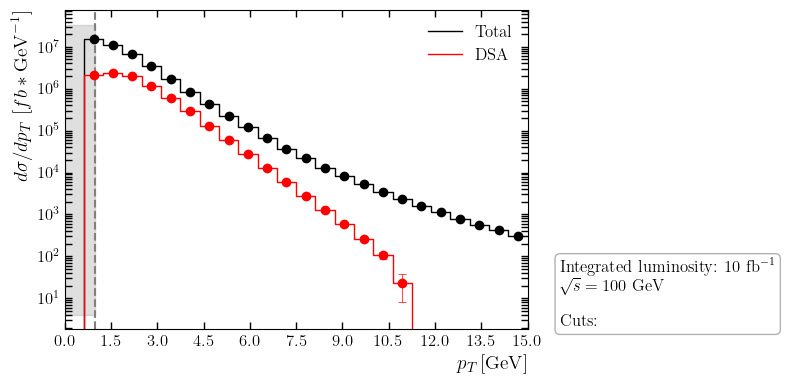

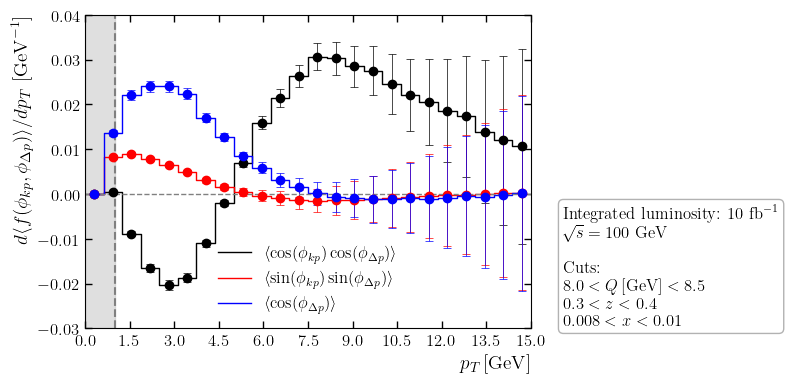

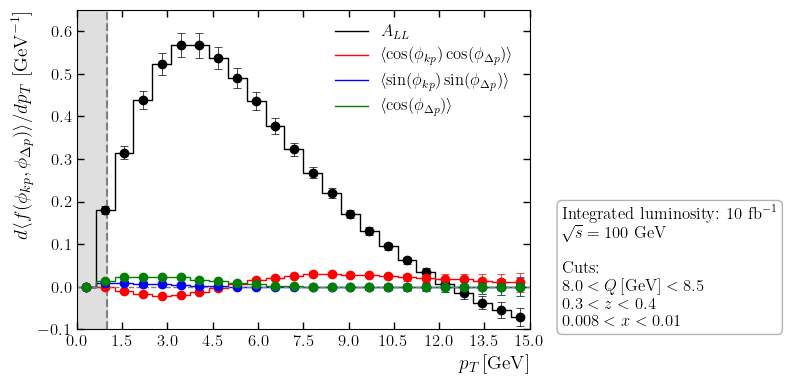

In [303]:
# plot relevant quantities 

Q_bins = np.linspace(6, 10.0, num=25)
pT_bins = np.linspace(0, 15.0, num=25)
phi_bins = [i/(2*np.pi) for i in range(15)]


lumi = 10
Q_min = 8.0 
Q_max = 8.5
y_min = 0.4
y_max = 0.5
z_min = 0.3
z_max = 0.4
x_min = 0.008
x_max = 0.01

tag = 'run6_ics'

plot_histogram([mc_df], 'pT', ['den_dsa', 'num_dsa'], 
                   {
                    # 'Q': [Q_min, Q_max],
                    # 'y': [y_min, y_max],
                    # 'z': [z_min, z_max],
                   }, 
                   lumi = lumi,
                   bins = pT_bins, 
                   y_scale='log', 
                   # x_scale='log',
                   # x_limits = [0, 11], 
                   nbins = 20, 
                   # y_limits = [10,10**9],
                   # zero_line = True,
                   min_pT_line = True,
                   y_label=r'$d\sigma /dp_T \,\,[fb*\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas=f'plots/dsa_pT_{tag}.pdf'
              )


# plot_histogram([mc_df, mc_df2], 'pT', ['<1>'], 
#                    {
#                     'Q': [Q_min, Q_max],
#                     # 'y': [y_min, y_max]
#                    }, 
#                    lumi = lumi,
#                    bins = pT_bins, 
#                    # y_scale='log', 
#                    # x_scale='log',
#                    # x_limits = [0, 11], 
#                    nbins = 10, 
#                    # y_limits = [10,10**9],
#                    zero_line = True,
#                    y_label=r'$dA_{LL} /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
#                    x_label=r'$p_T\, [\mathrm{GeV}]$',
#                    saveas=f'plots/A_LL_pT_{tag}.pdf'
#               )



plot_histogram([mc_df], 'pT', ['<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>','<cos(phi_Dp)>'], 
                   {
                    'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.03,0.04],
                   zero_line = True,
                   min_pT_line = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/LT_corr_{tag}.pdf'
                  )


plot_histogram([mc_df], 'pT', ['<1>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>','<cos(phi_Dp)>'], 
                   {
                    'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.1,0.65],
                   zero_line = True,
                   min_pT_line = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/LT_corr_{tag}.pdf'
                  )




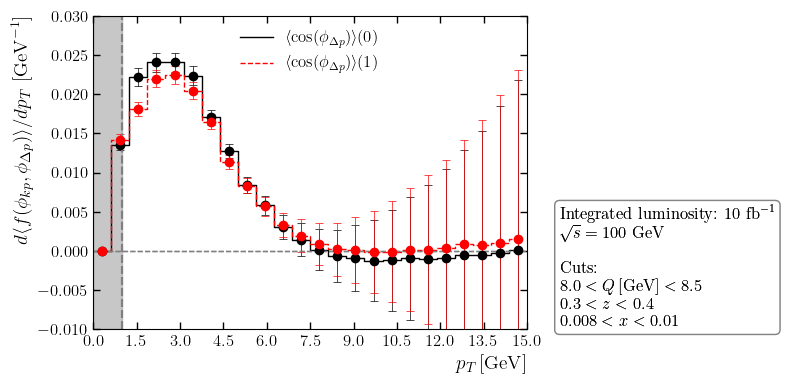

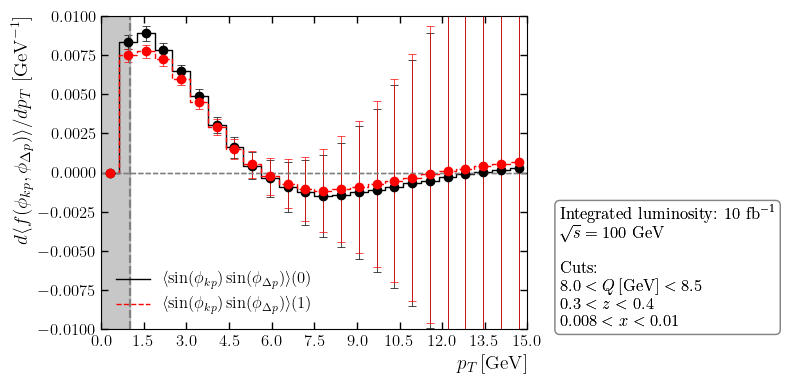

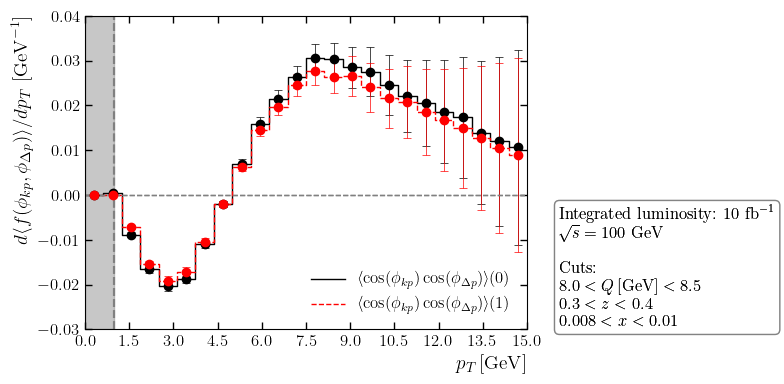

In [285]:
# comparison of different ICs

plot_histogram([mc_df, mc_df2], 'pT', ['<cos(phi_Dp)>'], 
                   {
                    'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.01,0.03],
                   zero_line = True,
                   min_pT_line = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/LT_corr_{tag}.pdf'
                  )


plot_histogram([mc_df, mc_df2], 'pT', ['<sin(phi_Dp)sin(phi_kp)>'], 
                   {
                    'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.01,0.01],
                   zero_line = True,
                   min_pT_line = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/LT_corr_{tag}.pdf'
                  )


plot_histogram([mc_df, mc_df2], 'pT', ['<cos(phi_Dp)cos(phi_kp)>'], 
                   {
                    'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.03,0.04],
                   zero_line = True,
                   min_pT_line = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/LT_corr_{tag}.pdf'
                  )